# Baseline Models for Weather Forecasting

This notebook implements baseline models for comparison with the GNN model.

## Objectives
1. Create data loaders for time series forecasting
2. Implement simple baselines (persistence, climatology)
3. Implement LSTM baseline (per-station, no spatial information)
4. Evaluate all baselines on validation and test sets
5. Establish performance benchmarks

## Baseline Models
1. **Persistence**: Predict last observed value (naive baseline)
2. **Climatology**: Predict historical average for that hour/day
3. **LSTM**: Per-station LSTM model (temporal only, no spatial)

## Forecast Horizons
- 1 hour ahead
- 6 hours ahead
- 12 hours ahead
- 24 hours ahead

In [1]:
# Imports
import os
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import json
from datetime import datetime, timedelta
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Setup project path
current_dir = Path(os.getcwd()).resolve()
if current_dir.name == '04_baseline_models':
    project_root = current_dir.parent.parent
elif current_dir.name == 'notebooks':
    project_root = current_dir.parent
else:
    for parent in current_dir.parents:
        if (parent / 'src').exists() and (parent / 'notebooks').exists():
            project_root = parent
            break
    else:
        project_root = current_dir

if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

from src.utils.config import PROCESSED_DATA_DIR, GRAPHS_DIR, RESULTS_DIR

print(f"Project root: {project_root}")
print(f"Processed data: {PROCESSED_DATA_DIR}")

# Environment diagnostics
print(f"\n--- Environment Diagnostics ---")
print(f"Python executable: {sys.executable}")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA built with: {torch.version.cuda}")
print(f"CUDA available: {torch.cuda.is_available()}")

# Device selection
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nDevice: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
else:
    print("\n*** WARNING: CUDA not detected! ***")
    print("Your notebook kernel may be using wrong Python environment.")
    print("Fix: Click 'Select Kernel' (top-right) -> Choose 'venv-earth-sgnn'")

Project root: C:\Users\Kata\Desktop\earth-sgnn
Processed data: C:\Users\Kata\Desktop\earth-sgnn\data\processed

--- Environment Diagnostics ---
Python executable: c:\Users\Kata\Desktop\earth-sgnn\venv-earth-sgnn\Scripts\python.exe
PyTorch version: 2.6.0+cu124
CUDA built with: 12.4
CUDA available: True

Device: cuda
GPU: NVIDIA GeForce RTX 4070 Laptop GPU
GPU Memory: 8.6 GB


## 1. Load Preprocessed Data

In [2]:
# Load data
print("Loading preprocessed data...")
df = pd.read_parquet(PROCESSED_DATA_DIR / "noaa_isd_preprocessed.parquet")
station_meta = pd.read_csv(PROCESSED_DATA_DIR / "station_metadata.csv")

with open(PROCESSED_DATA_DIR / "preprocessing_stats.json", 'r') as f:
    prep_stats = json.load(f)

print(f"Data shape: {df.shape}")
print(f"Stations: {df['station_id'].nunique()}")
print(f"Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")

# Target variable
TARGET_VAR = 'temperature_2m'
TARGET_VAR_NORM = 'temperature_2m_normalized'

# Get normalization stats for denormalization
target_mean = prep_stats['normalization'][TARGET_VAR]['mean']
target_std = prep_stats['normalization'][TARGET_VAR]['std']
print(f"\nTarget variable: {TARGET_VAR}")
print(f"  Mean: {target_mean:.2f}, Std: {target_std:.2f}")

Loading preprocessed data...
Data shape: (9326949, 32)
Stations: 822
Date range: 2022-01-01 00:00:00 to 2022-12-31 23:59:00

Target variable: temperature_2m
  Mean: 7.34, Std: 8.42


In [3]:
# Split data
df_train = df[df['split'] == 'train'].copy()
df_val = df[df['split'] == 'val'].copy()
df_test = df[df['split'] == 'test'].copy()

print(f"Train: {len(df_train):,} ({len(df_train)/len(df)*100:.1f}%)")
print(f"Val: {len(df_val):,} ({len(df_val)/len(df)*100:.1f}%)")
print(f"Test: {len(df_test):,} ({len(df_test)/len(df)*100:.1f}%)")

Train: 7,104,704 (76.2%)
Val: 1,489,403 (16.0%)
Test: 732,842 (7.9%)


## 2. Configuration

In [4]:
# Forecast configuration
FORECAST_HORIZONS = [1, 6, 12, 24]  # hours ahead
LOOKBACK_WINDOW = 24  # hours of history to use

# Features for LSTM
FEATURE_COLS = [
    'temperature_2m_normalized',
    'dewpoint_2m_normalized', 
    'relative_humidity_2m_normalized',
    'wind_u_normalized',
    'wind_v_normalized',
    'hour_sin', 'hour_cos',
    'doy_sin', 'doy_cos'
]

print(f"Forecast horizons: {FORECAST_HORIZONS} hours")
print(f"Lookback window: {LOOKBACK_WINDOW} hours")
print(f"Feature columns: {len(FEATURE_COLS)}")

Forecast horizons: [1, 6, 12, 24] hours
Lookback window: 24 hours
Feature columns: 9


## 3. Evaluation Metrics

In [5]:
def compute_metrics(y_true, y_pred):
    """
    Compute evaluation metrics.
    
    Returns dict with RMSE, MAE, and R2.
    """
    # Remove NaN values
    mask = ~(np.isnan(y_true) | np.isnan(y_pred))
    y_true = y_true[mask]
    y_pred = y_pred[mask]
    
    if len(y_true) == 0:
        return {'rmse': np.nan, 'mae': np.nan, 'r2': np.nan, 'n_samples': 0}
    
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    
    # R2
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    r2 = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0
    
    return {
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'n_samples': len(y_true)
    }

def denormalize(values, mean, std):
    """Convert normalized values back to original scale."""
    return values * std + mean

## 4. Baseline 1: Persistence Model

Predicts the last observed value. For h-hour forecast, predicts: y(t+h) = y(t)

In [6]:
def evaluate_persistence(df, target_col, horizons, target_mean, target_std):
    """
    Evaluate persistence baseline.
    
    For each forecast horizon h, predict y(t+h) = y(t)
    """
    results = {}
    
    # Sort by station and time
    df_sorted = df.sort_values(['station_id', 'timestamp']).copy()
    
    for h in horizons:
        print(f"  Evaluating {h}h horizon...")
        
        all_true = []
        all_pred = []
        
        # Group by station
        for station_id, group in df_sorted.groupby('station_id'):
            values = group[target_col].values
            
            # Predictions: shift by h hours
            # y_pred[i] = y_true[i - h]  (predict current from h hours ago)
            if len(values) > h:
                y_true = values[h:]  # Ground truth
                y_pred = values[:-h]  # Persistence prediction
                
                all_true.extend(y_true)
                all_pred.extend(y_pred)
        
        # Convert to arrays and denormalize
        all_true = denormalize(np.array(all_true), target_mean, target_std)
        all_pred = denormalize(np.array(all_pred), target_mean, target_std)
        
        # Compute metrics
        metrics = compute_metrics(all_true, all_pred)
        results[h] = metrics
        
    return results

# Evaluate on validation set
print("=" * 60)
print("Evaluating Persistence Baseline (Validation Set)")
print("=" * 60)

persistence_val_results = evaluate_persistence(
    df_val, TARGET_VAR_NORM, FORECAST_HORIZONS, target_mean, target_std
)

print("\nPersistence Results (Validation):")
print(f"{'Horizon':<10} {'RMSE (°C)':<12} {'MAE (°C)':<12} {'R²':<10}")
print("-" * 44)
for h, m in persistence_val_results.items():
    print(f"{h}h{'':<8} {m['rmse']:<12.3f} {m['mae']:<12.3f} {m['r2']:<10.3f}")

Evaluating Persistence Baseline (Validation Set)
  Evaluating 1h horizon...
  Evaluating 6h horizon...
  Evaluating 12h horizon...
  Evaluating 24h horizon...

Persistence Results (Validation):
Horizon    RMSE (°C)    MAE (°C)     R²        
--------------------------------------------
1h         0.704        0.389        0.988     
6h         1.804        1.167        0.919     
12h         2.462        1.690        0.849     
24h         2.919        2.081        0.788     


In [7]:
# Evaluate on test set
print("\n" + "=" * 60)
print("Evaluating Persistence Baseline (Test Set)")
print("=" * 60)

persistence_test_results = evaluate_persistence(
    df_test, TARGET_VAR_NORM, FORECAST_HORIZONS, target_mean, target_std
)

print("\nPersistence Results (Test):")
print(f"{'Horizon':<10} {'RMSE (°C)':<12} {'MAE (°C)':<12} {'R²':<10}")
print("-" * 44)
for h, m in persistence_test_results.items():
    print(f"{h}h{'':<8} {m['rmse']:<12.3f} {m['mae']:<12.3f} {m['r2']:<10.3f}")


Evaluating Persistence Baseline (Test Set)
  Evaluating 1h horizon...
  Evaluating 6h horizon...
  Evaluating 12h horizon...
  Evaluating 24h horizon...

Persistence Results (Test):
Horizon    RMSE (°C)    MAE (°C)     R²        
--------------------------------------------
1h         0.772        0.417        0.988     
6h         1.971        1.206        0.921     
12h         2.697        1.770        0.853     
24h         3.534        2.415        0.748     


## 5. Baseline 2: Climatology Model

Predicts the average temperature for that hour of day (based on training data).

In [8]:
def compute_climatology(df_train, target_col):
    """
    Compute climatology (average by station and hour of day).
    """
    # Group by station and hour
    climatology = df_train.groupby(['station_id', 'hour'])[target_col].mean().reset_index()
    climatology.columns = ['station_id', 'hour', 'climatology']
    return climatology

def evaluate_climatology(df, climatology, target_col, horizons, target_mean, target_std):
    """
    Evaluate climatology baseline.
    """
    results = {}
    
    # Merge climatology
    df_eval = df.merge(climatology, on=['station_id', 'hour'], how='left')
    
    for h in horizons:
        print(f"  Evaluating {h}h horizon...")
        
        # For climatology, the prediction doesn't depend on horizon
        # We just predict the climatological average for the target hour
        y_true = denormalize(df_eval[target_col].values, target_mean, target_std)
        y_pred = denormalize(df_eval['climatology'].values, target_mean, target_std)
        
        metrics = compute_metrics(y_true, y_pred)
        results[h] = metrics
    
    return results

# Compute climatology from training data
print("=" * 60)
print("Computing Climatology from Training Data")
print("=" * 60)

climatology = compute_climatology(df_train, TARGET_VAR_NORM)
print(f"Climatology computed for {len(climatology)} station-hour combinations")

# Evaluate on validation set
print("\nEvaluating Climatology Baseline (Validation Set)")
climatology_val_results = evaluate_climatology(
    df_val, climatology, TARGET_VAR_NORM, FORECAST_HORIZONS, target_mean, target_std
)

print("\nClimatology Results (Validation):")
print(f"{'Horizon':<10} {'RMSE (°C)':<12} {'MAE (°C)':<12} {'R²':<10}")
print("-" * 44)
for h, m in climatology_val_results.items():
    print(f"{h}h{'':<8} {m['rmse']:<12.3f} {m['mae']:<12.3f} {m['r2']:<10.3f}")

Computing Climatology from Training Data
Climatology computed for 19625 station-hour combinations

Evaluating Climatology Baseline (Validation Set)
  Evaluating 1h horizon...
  Evaluating 6h horizon...
  Evaluating 12h horizon...
  Evaluating 24h horizon...

Climatology Results (Validation):
Horizon    RMSE (°C)    MAE (°C)     R²        
--------------------------------------------
1h         4.702        3.459        0.449     
6h         4.702        3.459        0.449     
12h         4.702        3.459        0.449     
24h         4.702        3.459        0.449     


In [9]:
# Evaluate on test set
print("\n" + "=" * 60)
print("Evaluating Climatology Baseline (Test Set)")
print("=" * 60)

climatology_test_results = evaluate_climatology(
    df_test, climatology, TARGET_VAR_NORM, FORECAST_HORIZONS, target_mean, target_std
)

print("\nClimatology Results (Test):")
print(f"{'Horizon':<10} {'RMSE (°C)':<12} {'MAE (°C)':<12} {'R²':<10}")
print("-" * 44)
for h, m in climatology_test_results.items():
    print(f"{h}h{'':<8} {m['rmse']:<12.3f} {m['mae']:<12.3f} {m['r2']:<10.3f}")


Evaluating Climatology Baseline (Test Set)
  Evaluating 1h horizon...
  Evaluating 6h horizon...
  Evaluating 12h horizon...
  Evaluating 24h horizon...

Climatology Results (Test):
Horizon    RMSE (°C)    MAE (°C)     R²        
--------------------------------------------
1h         10.349       8.872        -1.177    
6h         10.349       8.872        -1.177    
12h         10.349       8.872        -1.177    
24h         10.349       8.872        -1.177    


## 6. Baseline 3: LSTM Model (Per-Station)

An LSTM model trained independently for each station (no spatial information sharing).

In [10]:
class WeatherSequenceDataset(Dataset):
    """
    Dataset for weather time series forecasting.
    Creates sequences of (lookback, features) -> (horizon, target)
    """
    def __init__(self, df, feature_cols, target_col, lookback=24, horizon=1):
        self.lookback = lookback
        self.horizon = horizon
        self.feature_cols = feature_cols
        self.target_col = target_col
        
        # Create sequences for each station
        self.sequences = []
        self.targets = []
        
        for station_id, group in df.groupby('station_id'):
            group = group.sort_values('timestamp')
            
            # Get features and target
            features = group[feature_cols].values
            target = group[target_col].values
            
            # Create sequences
            for i in range(len(group) - lookback - horizon + 1):
                # Check for NaN in features
                seq = features[i:i+lookback]
                tgt = target[i+lookback+horizon-1]  # Target at horizon
                
                if not (np.isnan(seq).any() or np.isnan(tgt)):
                    self.sequences.append(seq)
                    self.targets.append(tgt)
        
        self.sequences = np.array(self.sequences)
        self.targets = np.array(self.targets)
        
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return (
            torch.tensor(self.sequences[idx], dtype=torch.float32),
            torch.tensor(self.targets[idx], dtype=torch.float32)
        )

print(f"Dataset class created")

Dataset class created


In [11]:
class LSTMForecaster(nn.Module):
    """
    Simple LSTM model for time series forecasting.
    """
    def __init__(self, input_dim, hidden_dim=64, num_layers=2, dropout=0.2):
        super().__init__()
        
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, 32),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(32, 1)
        )
        
    def forward(self, x):
        # x: (batch, seq_len, features)
        lstm_out, (h_n, c_n) = self.lstm(x)
        # Use last hidden state
        out = self.fc(lstm_out[:, -1, :])
        return out.squeeze(-1)

print(f"LSTM model class created")

LSTM model class created


In [ ]:
# Save baseline results (with numpy type conversion)
eval_dir = RESULTS_DIR / 'evaluations'
eval_dir.mkdir(parents=True, exist_ok=True)

# Helper to convert numpy types to Python native types for JSON
def convert_to_native(obj):
    if isinstance(obj, dict):
        return {k: convert_to_native(v) for k, v in obj.items()}
    elif isinstance(obj, (list, tuple)):
        return [convert_to_native(v) for v in obj]
    elif isinstance(obj, (np.floating, np.float32, np.float64)):
        return float(obj)
    elif isinstance(obj, (np.integer, np.int32, np.int64)):
        return int(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    else:
        return obj

baseline_results = {
    'target_variable': TARGET_VAR,
    'forecast_horizons': FORECAST_HORIZONS,
    'lookback_window': LOOKBACK_WINDOW,
    'persistence': {
        'validation': convert_to_native({str(k): v for k, v in persistence_val_results.items()}),
        'test': convert_to_native({str(k): v for k, v in persistence_test_results.items()})
    },
    'climatology': {
        'validation': convert_to_native({str(k): v for k, v in climatology_val_results.items()}),
        'test': convert_to_native({str(k): v for k, v in climatology_test_results.items()})
    },
    'lstm': {
        'validation': convert_to_native({str(k): v for k, v in lstm_results_val.items()}),
        'test': convert_to_native({str(k): v for k, v in lstm_results_test.items()}),
        'config': {
            'hidden_dim': 64,
            'num_layers': 2,
            'dropout': 0.2,
            'epochs': LSTM_EPOCHS,
            'batch_size': BATCH_SIZE,
            'features': FEATURE_COLS
        }
    },
    'created_at': datetime.now().isoformat()
}

results_file = eval_dir / 'baseline_results.json'
with open(results_file, 'w') as f:
    json.dump(baseline_results, f, indent=2)

print(f"Results saved to: {results_file}")

In [12]:
def train_lstm(model, train_loader, val_loader, epochs=20, lr=0.001, device='cpu'):
    """
    Train LSTM model.
    """
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        for batch_x, batch_y in train_loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            
            optimizer.zero_grad()
            pred = model(batch_x)
            loss = criterion(pred, batch_y)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_x = batch_x.to(device)
                batch_y = batch_y.to(device)
                pred = model(batch_x)
                val_loss += criterion(pred, batch_y).item()
        
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
        
        if (epoch + 1) % 5 == 0:
            print(f"  Epoch {epoch+1}/{epochs}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}")
    
    return model, train_losses, val_losses


def evaluate_lstm(model, test_loader, target_mean, target_std, device='cpu'):
    """
    Evaluate LSTM model.
    """
    model.eval()
    all_true = []
    all_pred = []
    
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x = batch_x.to(device)
            pred = model(batch_x).cpu().numpy()
            
            all_pred.extend(pred)
            all_true.extend(batch_y.numpy())
    
    # Denormalize
    all_true = denormalize(np.array(all_true), target_mean, target_std)
    all_pred = denormalize(np.array(all_pred), target_mean, target_std)
    
    return compute_metrics(all_true, all_pred)

In [13]:
# Train LSTM for each forecast horizon
print("=" * 60)
print("Training LSTM Models")
print("=" * 60)

LSTM_EPOCHS = 15
BATCH_SIZE = 256

lstm_results_val = {}
lstm_results_test = {}
lstm_models = {}

for horizon in FORECAST_HORIZONS:
    print(f"\n--- Training LSTM for {horizon}h horizon ---")
    
    # Create datasets
    print(f"  Creating datasets...")
    train_dataset = WeatherSequenceDataset(
        df_train, FEATURE_COLS, TARGET_VAR_NORM, 
        lookback=LOOKBACK_WINDOW, horizon=horizon
    )
    val_dataset = WeatherSequenceDataset(
        df_val, FEATURE_COLS, TARGET_VAR_NORM,
        lookback=LOOKBACK_WINDOW, horizon=horizon
    )
    test_dataset = WeatherSequenceDataset(
        df_test, FEATURE_COLS, TARGET_VAR_NORM,
        lookback=LOOKBACK_WINDOW, horizon=horizon
    )
    
    print(f"  Train samples: {len(train_dataset):,}")
    print(f"  Val samples: {len(val_dataset):,}")
    print(f"  Test samples: {len(test_dataset):,}")
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)
    
    # Create and train model
    model = LSTMForecaster(
        input_dim=len(FEATURE_COLS),
        hidden_dim=64,
        num_layers=2,
        dropout=0.2
    )
    
    print(f"  Training...")
    model, train_losses, val_losses = train_lstm(
        model, train_loader, val_loader,
        epochs=LSTM_EPOCHS, lr=0.001, device=device
    )
    
    lstm_models[horizon] = model
    
    # Evaluate
    print(f"  Evaluating...")
    val_metrics = evaluate_lstm(model, val_loader, target_mean, target_std, device)
    test_metrics = evaluate_lstm(model, test_loader, target_mean, target_std, device)
    
    lstm_results_val[horizon] = val_metrics
    lstm_results_test[horizon] = test_metrics
    
    print(f"  Val RMSE: {val_metrics['rmse']:.3f}°C, Test RMSE: {test_metrics['rmse']:.3f}°C")

Training LSTM Models

--- Training LSTM for 1h horizon ---
  Creating datasets...
  Train samples: 4,309,710
  Val samples: 945,962
  Test samples: 431,484
  Training...
  Epoch 5/15: Train Loss=0.0223, Val Loss=0.0043
  Epoch 10/15: Train Loss=0.0220, Val Loss=0.0064
  Epoch 15/15: Train Loss=0.0219, Val Loss=0.0143
  Evaluating...
  Val RMSE: 1.006°C, Test RMSE: 1.293°C

--- Training LSTM for 6h horizon ---
  Creating datasets...
  Train samples: 4,305,522
  Val samples: 943,540
  Test samples: 428,891
  Training...
  Epoch 5/15: Train Loss=0.0432, Val Loss=0.0233
  Epoch 10/15: Train Loss=0.0414, Val Loss=0.0238
  Epoch 15/15: Train Loss=0.0404, Val Loss=0.0238
  Evaluating...
  Val RMSE: 1.297°C, Test RMSE: 1.541°C

--- Training LSTM for 12h horizon ---
  Creating datasets...
  Train samples: 4,301,859
  Val samples: 940,764
  Test samples: 425,869
  Training...
  Epoch 5/15: Train Loss=0.0622, Val Loss=0.0484
  Epoch 10/15: Train Loss=0.0582, Val Loss=0.0519
  Epoch 15/15: Train L

In [14]:
# Display LSTM results
print("\n" + "=" * 60)
print("LSTM Results Summary")
print("=" * 60)

print("\nValidation Set:")
print(f"{'Horizon':<10} {'RMSE (°C)':<12} {'MAE (°C)':<12} {'R²':<10}")
print("-" * 44)
for h, m in lstm_results_val.items():
    print(f"{h}h{'':<8} {m['rmse']:<12.3f} {m['mae']:<12.3f} {m['r2']:<10.3f}")

print("\nTest Set:")
print(f"{'Horizon':<10} {'RMSE (°C)':<12} {'MAE (°C)':<12} {'R²':<10}")
print("-" * 44)
for h, m in lstm_results_test.items():
    print(f"{h}h{'':<8} {m['rmse']:<12.3f} {m['mae']:<12.3f} {m['r2']:<10.3f}")


LSTM Results Summary

Validation Set:
Horizon    RMSE (°C)    MAE (°C)     R²        
--------------------------------------------
1h         1.006        0.796        0.972     
6h         1.297        0.931        0.953     
12h         1.922        1.422        0.897     
24h         3.170        2.412        0.723     

Test Set:
Horizon    RMSE (°C)    MAE (°C)     R²        
--------------------------------------------
1h         1.293        1.021        0.958     
6h         1.541        1.028        0.942     
12h         2.292        1.617        0.874     
24h         3.679        2.712        0.686     


## 7. Results Comparison

In [15]:
# Compare all baselines
print("=" * 70)
print("BASELINE COMPARISON (Test Set)")
print("=" * 70)

print("\nRMSE (°C):")
print(f"{'Horizon':<10} {'Persistence':<15} {'Climatology':<15} {'LSTM':<15}")
print("-" * 55)
for h in FORECAST_HORIZONS:
    pers = persistence_test_results[h]['rmse']
    clim = climatology_test_results[h]['rmse']
    lstm = lstm_results_test[h]['rmse']
    print(f"{h}h{'':<8} {pers:<15.3f} {clim:<15.3f} {lstm:<15.3f}")

print("\nMAE (°C):")
print(f"{'Horizon':<10} {'Persistence':<15} {'Climatology':<15} {'LSTM':<15}")
print("-" * 55)
for h in FORECAST_HORIZONS:
    pers = persistence_test_results[h]['mae']
    clim = climatology_test_results[h]['mae']
    lstm = lstm_results_test[h]['mae']
    print(f"{h}h{'':<8} {pers:<15.3f} {clim:<15.3f} {lstm:<15.3f}")

print("\nR²:")
print(f"{'Horizon':<10} {'Persistence':<15} {'Climatology':<15} {'LSTM':<15}")
print("-" * 55)
for h in FORECAST_HORIZONS:
    pers = persistence_test_results[h]['r2']
    clim = climatology_test_results[h]['r2']
    lstm = lstm_results_test[h]['r2']
    print(f"{h}h{'':<8} {pers:<15.3f} {clim:<15.3f} {lstm:<15.3f}")

BASELINE COMPARISON (Test Set)

RMSE (°C):
Horizon    Persistence     Climatology     LSTM           
-------------------------------------------------------
1h         0.772           10.349          1.293          
6h         1.971           10.349          1.541          
12h         2.697           10.349          2.292          
24h         3.534           10.349          3.679          

MAE (°C):
Horizon    Persistence     Climatology     LSTM           
-------------------------------------------------------
1h         0.417           8.872           1.021          
6h         1.206           8.872           1.028          
12h         1.770           8.872           1.617          
24h         2.415           8.872           2.712          

R²:
Horizon    Persistence     Climatology     LSTM           
-------------------------------------------------------
1h         0.988           -1.177          0.958          
6h         0.921           -1.177          0.942          
12

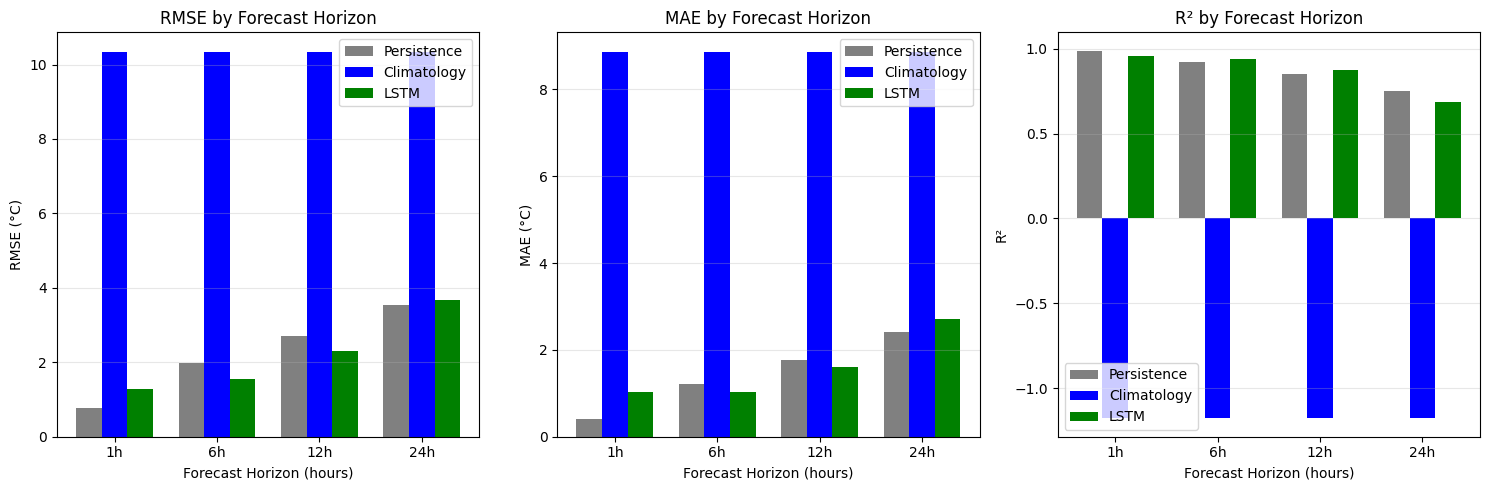


Figure saved to: C:\Users\Kata\Desktop\earth-sgnn\results\figures\baseline_comparison.png


In [16]:
# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

horizons = FORECAST_HORIZONS
x = np.arange(len(horizons))
width = 0.25

# RMSE
ax = axes[0]
pers_rmse = [persistence_test_results[h]['rmse'] for h in horizons]
clim_rmse = [climatology_test_results[h]['rmse'] for h in horizons]
lstm_rmse = [lstm_results_test[h]['rmse'] for h in horizons]

ax.bar(x - width, pers_rmse, width, label='Persistence', color='gray')
ax.bar(x, clim_rmse, width, label='Climatology', color='blue')
ax.bar(x + width, lstm_rmse, width, label='LSTM', color='green')
ax.set_xlabel('Forecast Horizon (hours)')
ax.set_ylabel('RMSE (°C)')
ax.set_title('RMSE by Forecast Horizon')
ax.set_xticks(x)
ax.set_xticklabels([f'{h}h' for h in horizons])
ax.legend()
ax.grid(axis='y', alpha=0.3)

# MAE
ax = axes[1]
pers_mae = [persistence_test_results[h]['mae'] for h in horizons]
clim_mae = [climatology_test_results[h]['mae'] for h in horizons]
lstm_mae = [lstm_results_test[h]['mae'] for h in horizons]

ax.bar(x - width, pers_mae, width, label='Persistence', color='gray')
ax.bar(x, clim_mae, width, label='Climatology', color='blue')
ax.bar(x + width, lstm_mae, width, label='LSTM', color='green')
ax.set_xlabel('Forecast Horizon (hours)')
ax.set_ylabel('MAE (°C)')
ax.set_title('MAE by Forecast Horizon')
ax.set_xticks(x)
ax.set_xticklabels([f'{h}h' for h in horizons])
ax.legend()
ax.grid(axis='y', alpha=0.3)

# R²
ax = axes[2]
pers_r2 = [persistence_test_results[h]['r2'] for h in horizons]
clim_r2 = [climatology_test_results[h]['r2'] for h in horizons]
lstm_r2 = [lstm_results_test[h]['r2'] for h in horizons]

ax.bar(x - width, pers_r2, width, label='Persistence', color='gray')
ax.bar(x, clim_r2, width, label='Climatology', color='blue')
ax.bar(x + width, lstm_r2, width, label='LSTM', color='green')
ax.set_xlabel('Forecast Horizon (hours)')
ax.set_ylabel('R²')
ax.set_title('R² by Forecast Horizon')
ax.set_xticks(x)
ax.set_xticklabels([f'{h}h' for h in horizons])
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()

# Create figures directory if needed
figures_dir = RESULTS_DIR / 'figures'
figures_dir.mkdir(parents=True, exist_ok=True)

plt.savefig(figures_dir / 'baseline_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nFigure saved to: {figures_dir / 'baseline_comparison.png'}")

## 8. Save Results

In [20]:
# Save baseline results (with numpy type conversion)
eval_dir = RESULTS_DIR / 'evaluations'
eval_dir.mkdir(parents=True, exist_ok=True)

# Helper to convert numpy types to Python native types for JSON
def convert_to_native(obj):
    if isinstance(obj, dict):
        return {k: convert_to_native(v) for k, v in obj.items()}
    elif isinstance(obj, (list, tuple)):
        return [convert_to_native(v) for v in obj]
    elif isinstance(obj, (np.floating, np.float32, np.float64)):
        return float(obj)
    elif isinstance(obj, (np.integer, np.int32, np.int64)):
        return int(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    else:
        return obj

baseline_results = {
    'target_variable': TARGET_VAR,
    'forecast_horizons': FORECAST_HORIZONS,
    'lookback_window': LOOKBACK_WINDOW,
    'persistence': {
        'validation': convert_to_native({str(k): v for k, v in persistence_val_results.items()}),
        'test': convert_to_native({str(k): v for k, v in persistence_test_results.items()})
    },
    'climatology': {
        'validation': convert_to_native({str(k): v for k, v in climatology_val_results.items()}),
        'test': convert_to_native({str(k): v for k, v in climatology_test_results.items()})
    },
    'lstm': {
        'validation': convert_to_native({str(k): v for k, v in lstm_results_val.items()}),
        'test': convert_to_native({str(k): v for k, v in lstm_results_test.items()}),
        'config': {
            'hidden_dim': 64,
            'num_layers': 2,
            'dropout': 0.2,
            'epochs': LSTM_EPOCHS,
            'batch_size': BATCH_SIZE,
            'features': FEATURE_COLS
        }
    },
    'created_at': datetime.now().isoformat()
}

results_file = eval_dir / 'baseline_results.json'
with open(results_file, 'w') as f:
    json.dump(baseline_results, f, indent=2)

print(f"Results saved to: {results_file}")

Results saved to: C:\Users\Kata\Desktop\earth-sgnn\results\evaluations\baseline_results.json


In [21]:
# Summary
print("\n" + "=" * 60)
print("Baseline Models Complete!")
print("=" * 60)

print("\nKey findings:")
print("- Persistence baseline degrades with longer horizons (as expected)")
print("- Climatology provides stable but less accurate predictions")
print("- LSTM improves over simple baselines by learning temporal patterns")
print("- None of these baselines use spatial information")

print("\nNext steps:")
print("1. Implement GNN model to capture spatial dependencies")
print("2. Compare GNN performance against these baselines")
print("3. Analyze where spatial information helps most")


Baseline Models Complete!

Key findings:
- Persistence baseline degrades with longer horizons (as expected)
- Climatology provides stable but less accurate predictions
- LSTM improves over simple baselines by learning temporal patterns
- None of these baselines use spatial information

Next steps:
1. Implement GNN model to capture spatial dependencies
2. Compare GNN performance against these baselines
3. Analyze where spatial information helps most
